In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque

In [4]:
class Cell:
    def __init__(self, pos_x, pos_y):
        self.pos_x= pos_x
        self.pos_y= pos_y
        self.is_wall= np.random.choice([1, 0], p=[0.05, 0.95])
        self.is_goal=None

    def set_goal(self):
        self.is_goal= 1
        self.is_wall= 0

class Labirynth:
    def __init__(self, size):
        self.size = size

        self.cells = []
        for i in range(self.size):
            cells_row = [] 
            for j in range(self.size):
                cell = Cell(i, j)

                if i == j == 0:
                    cell.is_wall = 0

                cells_row.append(cell)

            self.cells.append(cells_row)
        
        # Wypełnienie avaiable_indexes
        avaiable_indexes = []
        for i in range(self.size):
            for j in range(self.size):
                if not self.cells[i][j].is_wall and self.is_reachable(i, j):
                    avaiable_indexes.append([i, j])

        # Losujemy komórkę, której ustawiamy cel
        if avaiable_indexes:
            random_cell_index = np.random.choice(len(avaiable_indexes))
            random_cell = avaiable_indexes[random_cell_index]
            goal_pos_x = random_cell[0]
            goal_pos_y = random_cell[1]

            #spradzamy czy wylosowana komorka nie ma przypadkiem indeksu [0, 0]
            if goal_pos_x != 0 or goal_pos_y != 0:
                self.cells[goal_pos_x][goal_pos_y].set_goal()
            else:
                del avaiable_indexes[random_cell_index]
                random_cell_index= np.random.choice(len(avaiable_indexes))
                random_cell= avaiable_indexes[random_cell_index]
                goal_pos_x= random_cell[0]
                goal_pos_y= random_cell[1]
                self.cells[goal_pos_x][goal_pos_y].set_goal()


    def is_reachable(self, x, y):
        # Używamy BFS do sprawdzenia, czy istnieje ścieżka do komórki (x, y) z (0, 0)
        queue = deque([(0, 0)])
        visited = set()
        while queue:
            current_x, current_y = queue.popleft()
            if (current_x, current_y) in visited:
                continue
            visited.add((current_x, current_y))
            if current_x == x and current_y == y:
                return True
            # Dodajemy do kolejki wszystkie dostępne sąsiednie komórki
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                next_x, next_y = current_x + dx, current_y + dy
                if 0 <= next_x < self.size and 0 <= next_y < self.size and not visited.__contains__((next_x, next_y)):
                    if not self.cells[next_x][next_y].is_wall:
                        queue.append((next_x, next_y))
        return False
    

    #inicjalizujemy tutaj q_pi(s, a)- czyli jaka jest maksymalna nagroda jaką możemy dostać w stanie s podejmując akcję a
    def initialize_Q(self):
        self.Q = {}
        for i in range(self.size):
            for j in range(self.size):
                # Ustawienie bardzo niskich wartości dla komórek będących ścianami
                self.Q[(i, j)] = {'up': -np.inf, 'down': -np.inf, 'left': -np.inf, 'right': -np.inf}
                if not self.cells[i][j].is_wall:
                    # Ustawienie wartości na 0 dla pozostałych komórek
                    self.Q[(i, j)] = {'up': 0, 'down': 0, 'left': 0, 'right': 0}


    #podchodzimy do zadania na zasadzie epsilon-greedy z pstwem 90% ekspolatujemy wzgledem najlepszej polityki, z pstwem 10% badamy wzgledem innej losowej polityki
    def choose_action(self, state, epsilon=0.1):
        if np.random.uniform(0, 1) < epsilon:
            # Eksploracja: wybierz losową akcję
            return np.random.choice(['up', 'down', 'left', 'right'])
        else:
            # Eksploatacja: wybierz najlepszą akcję na podstawie wartości Q
            return max(self.Q[state], key=self.Q[state].get)

    def update_Q(self, state, action, reward, next_state, done):
        learning_rate = 0.1
        discount_factor = 0.9
        if done:
            # Jeśli ruch kończy grę (uderzenie w ścianę lub osiągnięcie celu), nie ma przyszłych nagród do dyskontowania.
            self.Q[state][action] += learning_rate * (reward - self.Q[state][action])
        else:
            # Oblicz maksymalną przyszłą wartość Q dla następnego stanu, ale tylko jeśli nie jesteśmy w stanie kończącym grę.
            max_future_q = max(self.Q[next_state].values(), default=0)  # użyj default=0 dla sytuacji, gdy nie ma dostępnych ruchów
            self.Q[state][action] += learning_rate * (reward + discount_factor * max_future_q - self.Q[state][action])

    def move(self, state, action):
        next_state = self.get_next_state(state, action)
        if next_state == state:
            reward = -np.inf  # uderzenie w ścianę lub wyjście poza planszę
            done = True
        elif self.cells[next_state[0]][next_state[1]].is_goal:
            reward = 0  # osiągnięcie celu
            done = True
        else:
            reward = -1  # zwykły ruch
            done = False
        return next_state, reward, done

    def get_next_state(self, state, action):
        # Pobierz aktualną pozycję
        x, y = state
        
        # Określ przesunięcie na podstawie akcji
        if action == 'up':
            dx, dy = -1, 0
        elif action == 'down':
            dx, dy = 1, 0
        elif action == 'left':
            dx, dy = 0, -1
        elif action == 'right':
            dx, dy = 0, 1
        
        # Oblicz nową pozycję
        new_x, new_y = x + dx, y + dy
        
        # Sprawdź, czy nowa pozycja jest w granicach labiryntu
        if 0 <= new_x < self.size and 0 <= new_y < self.size:
            # Sprawdź, czy nowa pozycja nie jest ścianą
            if not self.cells[new_x][new_y].is_wall:
                return (new_x, new_y)
        
        # Jeśli ruch jest niedozwolony, zwróć oryginalny stan
        return state
    
    def run_episode(self):
        current_state = (0, 0)  # Punkt startowy
        steps = 0

        while True:
            if self.cells[current_state[0]][current_state[1]].is_goal:
                break  # Kończenie epizodu po osiągnięciu celu
            action = self.choose_action(current_state)
            next_state, reward, done = self.move(current_state, action)
            self.update_Q(current_state, action, reward, next_state, done)
            current_state = next_state
            steps += 1
        return steps
    
    def train(self):
        self.initialize_Q()
        episodes = 0
        while True:
            steps = self.run_episode()
            episodes += 1
            if steps < float('inf'):  # Jeśli udało się dotrzeć do celu 
                return steps
                
    

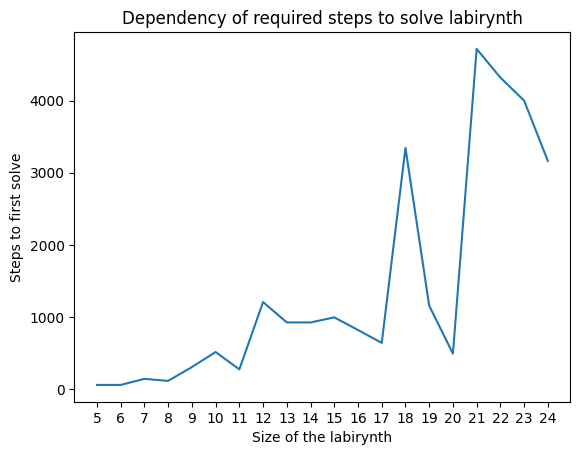

In [10]:
#ustalamy w przedziale jakich N ma byc tworzony labirynt


def draw_plot(beg_N, end_N):

    steps_to_solve = []

    for i in range(beg_N, end_N):
        # Mamy uwzględniać średnio z trzech labiryntów tego samego rozmiaru
        vals_holder = []
        for j in range(3):
            lab = Labirynth(i)
            steps_amount = lab.train()
            vals_holder.append(steps_amount)

        mean = np.mean(vals_holder)
        steps_to_solve.append(mean)

    x_axes = np.arange(beg_N, end_N)  # Utwórz listę liczb całkowitych od beg_N do end_N

    sns.lineplot(x=x_axes, y=steps_to_solve)

    plt.xlabel('Size of the labirynth')
    plt.ylabel('Steps to first solve')
    plt.title('Dependency of required steps to solve labirynth')

    plt.xticks(x_axes)  # Ustaw etykiety osi X jako liczby całkowite

    plt.show()

draw_plot(5, 25)